In [11]:
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
from rpy2.robjects import r, pandas2ri
pandas2ri.activate()

In [2]:
FPS = 60
INTERVAL_SIZE = 1
PD_STEP_SIZE = 10

In [3]:
trials_pd_paths = sorted(glob.glob("../new_exp_data/pd_summaries/pd_summaries/cv*tt*.rdata"))

trial_pds = []

for path in trials_pd_paths:
    r['load'](path)
    trial = r['df.ext']
    trial.frame = np.arange(10, 2710, 10).tolist() * 4
    trial_pds.append(trial)   

/home/hector/miniconda3/envs/diss/lib/python3.5/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


In [4]:
mass_pd_list = []
force_pd_list = []

for trial_pd in trial_pds:
    
    window_size = int(FPS * INTERVAL_SIZE / PD_STEP_SIZE)
    pd_mass = trial_pd[["frame", "pd.mass.rtheta"]].groupby("frame").agg({"pd.mass.rtheta": np.mean})
    pd_mass = pd_mass["pd.mass.rtheta"].rolling(window=window_size).mean().values[window_size-1::window_size]
    mass_pd_list.append(pd_mass)

    pd_force = trial_pd[["frame", "pd.rel.rtheta"]].groupby("frame").agg({"pd.rel.rtheta": np.mean})
    pd_force = pd_force["pd.rel.rtheta"].rolling(window=window_size).mean().values[window_size-1::window_size]
    force_pd_list.append(pd_force)

In [5]:
confusing_force_intervals = pd.read_csv("cogsci_images/confusing_videos/"\
                                        "confusing_xy_vxvy/confusing_xy_vxvy_force_interval_description.csv")
confusing_mass_intervals = pd.read_csv("cogsci_images/confusing_videos/"\
                                       "confusing_xy_vxvy/confusing_xy_vxvy_mass_interval_description.csv")
obvious_force_intervals = pd.read_csv("cogsci_images/obvious_videos/"\
                                        "obvious_xy_vxvy/obvious_xy_vxvy_force_interval_description.csv")
obvious_mass_intervals = pd.read_csv("cogsci_images/obvious_videos/"\
                                       "obvious_xy_vxvy/obvious_xy_vxvy_mass_interval_description.csv")

In [6]:
confusing_mass_intervals.shape

(15, 7)

In [8]:
force_intervals = pd.concat([confusing_force_intervals, obvious_force_intervals])
force_intervals["is_obvious_interval"] = force_intervals["solution"] == force_intervals["rnn_preferred_option"]
mass_intervals = pd.concat([confusing_mass_intervals, obvious_mass_intervals])
mass_intervals["is_obvious_interval"] = mass_intervals["solution"] == mass_intervals["rnn_preferred_option"]

In [9]:
def get_average_pd_for_intervals(intervals, pd_list):
    pd_values = []
    
    for interval_i in range(intervals.shape[0]):
        interval = intervals.iloc[interval_i]
        trial_number = interval.trial_number
        window_start = interval.window_start
        window_end = interval.window_end
        pd_value = np.mean(pd_list[trial_number][window_start:window_end])
        pd_values.append(pd_value)
    return pd_values

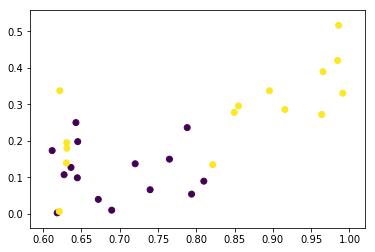

In [12]:
average_force_pd = get_average_pd_for_intervals(force_intervals, force_pd_list)
force_intervals["pd"] = average_force_pd

plt.scatter(force_intervals.rnn_preferred_option_probability, force_intervals.pd, c=force_intervals.is_obvious_interval)

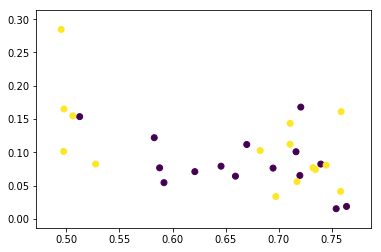

In [13]:
average_mass_pd = get_average_pd_for_intervals(mass_intervals, mass_pd_list)
mass_intervals["pd"] = average_mass_pd

plt.scatter(mass_intervals.rnn_preferred_option_probability, mass_intervals.pd, c=mass_intervals.is_obvious_interval)